In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [6]:
def get_quantized_value_options(total_bits, fractional_bits, signed=True, enforce_symmetry=False):
    if signed:
        max_value = 2**(total_bits - 1) - 1
    else:
        max_value = 2**total_bits - 1
    if signed:
        if enforce_symmetry:
            min_value = -1 * max_value
        else:
            min_value = -(2 ** (total_bits - 1))
    else:
        min_value = 0
    return np.arange(min_value, max_value) / (2 ** fractional_bits)


def quantize(
    numbers,
    total_bits,
    fractional_bits,
    signed=True,
    enforce_symmetry=False,
):  # Copied from requantization_sim.ipynb

    numbers = np.round(numbers * 2**fractional_bits)
    if signed:
        max_value = 2 ** (total_bits - 1) - 1
    else:
        max_value = 2**total_bits - 1
    numbers[numbers > max_value] = max_value
    if signed:
        if enforce_symmetry:
            min_value = -1 * max_value
        else:
            min_value = -(2 ** (total_bits - 1))
        numbers[numbers < min_value] = min_value
    numbers /= 2.0**fractional_bits
    return numbers


def get_probabilities(stddev, value_options):

    probabilities = np.zeros_like(value_options)
    for ind in range(len(value_options)):
        if ind == 0:
            integral_start = -np.inf
        else:
            integral_start = (
                value_options[ind - 1]
                + value_options[ind]
            ) / 2

        if ind == len(value_options) - 1:
            integral_end = np.inf
        else:
            integral_end = (
                value_options[ind]
                + value_options[ind + 1]
            ) / 2
        integral_value = (
            np.sqrt(np.pi)
            * stddev
            / 2
            * (
                scipy.special.erf(integral_end / stddev)
                - scipy.special.erf(integral_start / stddev)
            )
        )
        probabilities[ind] = integral_value

    probabilities /= np.sum(probabilities)
    return probabilities


def calculate_variance(values, probabilities):
    return np.sum(probabilities * values**2) - np.sum(probabilities * values) ** 2

In [9]:
def requantization_sim(
    input_stddev_array,
    equalization_coeffs,
):

    initial_quantized_value_options = get_quantized_value_options(18, 17)
    # input_stddev_array = np.full_like(equalization_coeffs, input_stddev)

    input_stddev_unique = np.unique(input_stddev_array)
    initial_quantized_probabilities_array = np.zeros(
        (len(initial_quantized_value_options), len(input_stddev_unique))
    )
    for stddev_ind, use_stddev in enumerate(input_stddev_unique):
        initial_quantized_probabilities_array[:, stddev_ind] = get_probabilities(
            use_stddev, initial_quantized_value_options
        )

    final_quantized_value_options = get_quantized_value_options(
        4, 3, enforce_symmetry=True
    )
    final_variances = np.zeros_like(equalization_coeffs)
    for equalization_ind, equalization_coeff in enumerate(equalization_coeffs):

        initial_quantized_probabilities = initial_quantized_probabilities_array[
            :,
            np.where(input_stddev_unique == input_stddev_array[equalization_ind])[0][0],
        ]
        equalized_value_options = initial_quantized_value_options * equalization_coeff
        final_quantized_probabilities = np.zeros_like(final_quantized_value_options)
        equalized_value_options_quantized = quantize(
            equalized_value_options, 4, 3, enforce_symmetry=True
        )
        for ind in range(len(final_quantized_value_options)):
            final_quantized_probabilities[ind] = np.sum(
                initial_quantized_probabilities[
                    np.where(
                        equalized_value_options_quantized
                        == final_quantized_value_options[ind]
                    )
                ]
            )

        variance = calculate_variance(
            final_quantized_value_options, final_quantized_probabilities
        )
        final_variances[equalization_ind] = variance

    return final_variances

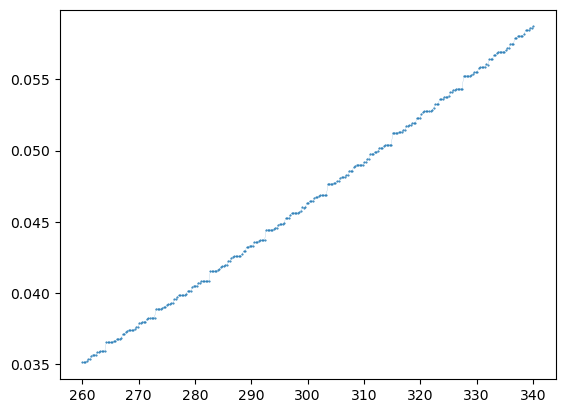

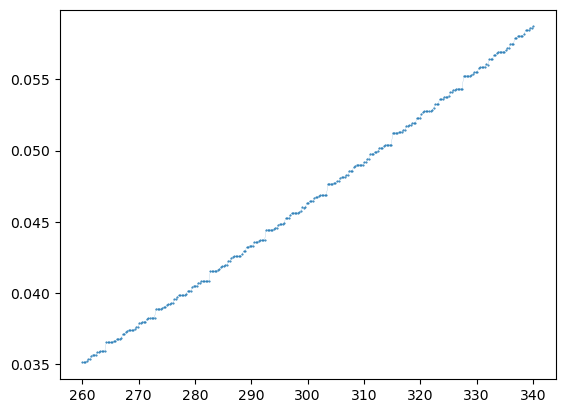

In [ ]:
equalization_coeffs = np.linspace(260, 340, num=300)
final_variances = requantization_sim(
    np.full_like(equalization_coeffs, 1e-3),
    equalization_coeffs,
)
plt.plot(
    equalization_coeffs,
    final_variances,
    ".-",
    markersize=1,
    linewidth=0.1,
)
plt.show()

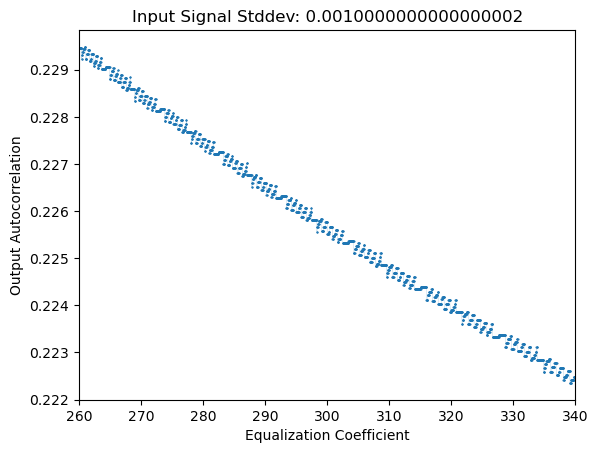

In [54]:
equalization_coeffs = np.linspace(260, 340, num=3000)
input_stddev_values = np.full_like(equalization_coeffs, 1e-3)
final_variances = requantization_sim(
    input_stddev_values,
    equalization_coeffs,
)

plt.plot(
    equalization_coeffs,
    final_variances,
    ".-",
    markersize=1,
    linewidth=0.1,
)
# plt.plot(
#    equalization_coeffs,
#    (input_stddev * equalization_coeffs)**2,
#    ".-",
#    markersize=1,
#    linewidth=0.1,
# )
plt.xlim([np.min(equalization_coeffs), np.max(equalization_coeffs)])
# plt.ylim([0, None])
plt.xlabel("Equalization Coefficient")
plt.ylabel("Output Autocorrelation")
plt.title(f"Input Signal Stddev: {np.mean(input_stddev_values)}")
plt.show()

278.2608695652174


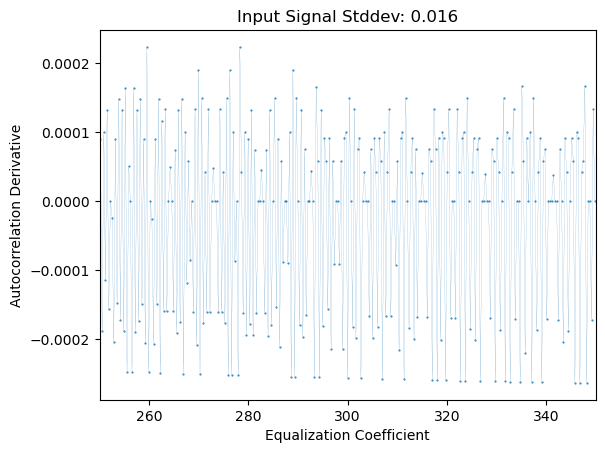

In [33]:
equalization_coeffs_derivative = (
    equalization_coeffs[1:] + equalization_coeffs[:-1]
) / 2
variances_derivative = final_variances[1:] - final_variances[:-1]
optimal_equalization_coeff = equalization_coeffs_derivative[
    np.where(variances_derivative == np.max(variances_derivative))[0][0]
]
print(optimal_equalization_coeff)
plt.plot(
    equalization_coeffs_derivative,
    variances_derivative,
    ".-",
    markersize=1,
    linewidth=0.1,
)
plt.xlim([np.min(equalization_coeffs), np.max(equalization_coeffs)])
plt.xlabel("Equalization Coefficient")
plt.ylabel("Autocorrelation Derivative")
plt.title(f"Input Signal Stddev: {input_stddev}")
plt.show()

In [34]:
plt.plot(
    final_quantized_value_options,
    final_quantized_probabilities,
    ".-",
    markersize=1,
    linewidth=0.3,
    label="Output"
)
gaussian_fit = np.exp(-(final_quantized_value_options**2) / variance)
gaussian_fit /= np.sum(gaussian_fit)
plt.plot(
    final_quantized_value_options,
    gaussian_fit,
    ".-",
    markersize=1,
    linewidth=0.3,
    label="Gaussian fit",
)
plt.xlabel("Value")
plt.ylabel("Output Probability")
plt.legend()

NameError: name 'final_quantized_value_options' is not defined

In [ ]:
channel_width = 24e3
frequencies = np.arange(41e6, 85e6, channel_width)

In [ ]:
100/(85e6-41e6)

2.2727272727272728e-06

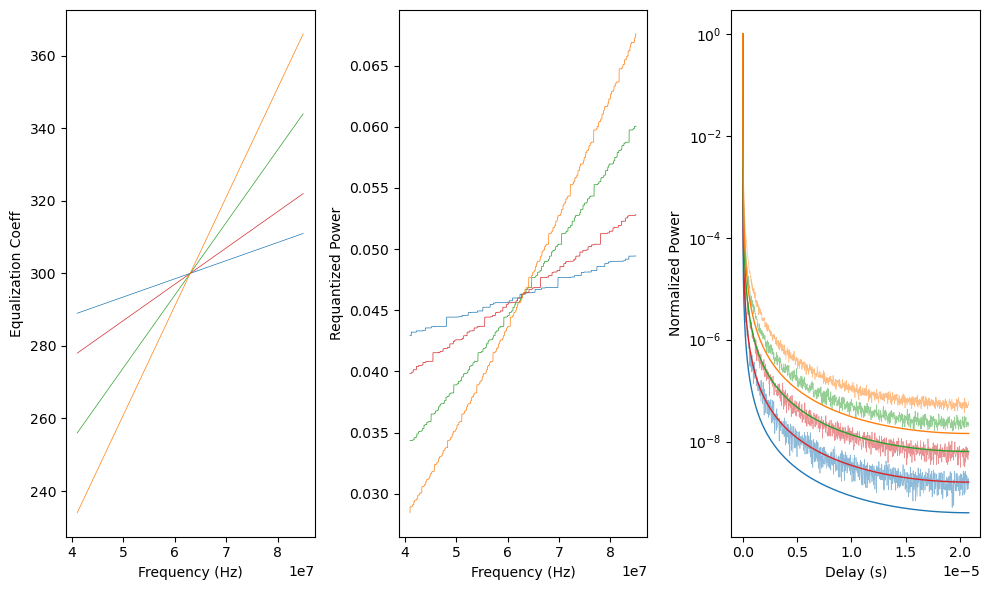

In [ ]:
delays = np.fft.fftfreq(len(frequencies), d=channel_width)
keep_delay_inds = np.where(delays >= 0)[0]
delays = delays[keep_delay_inds]
fig, ax = plt.subplots(ncols=3, figsize=(10,6))

colors = [
    "tab:blue",
    "tab:red",
    "tab:green", "tab:orange",
]
for ind, equalization_coeff_slope in enumerate([0.5e-6, 1e-6, 2e-6, 3e-6]):
    mean_eq_coeff = 300
    equalization_coeffs = (
        equalization_coeff_slope * frequencies 
        + mean_eq_coeff
        - equalization_coeff_slope * np.mean(frequencies)
    )
    fft_no_requant = np.fft.fft(input_stddev * equalization_coeffs)[keep_delay_inds]
    fft_no_requant /= np.max(fft_no_requant)

    requantized_vals = requantization_sim(
        initial_quantized_value_options,
        initial_quantized_probabilities,
        equalization_coeffs,
    )
    requantized_vals_fft = np.fft.fft(requantized_vals)[keep_delay_inds]
    requantized_vals_fft /= np.max(requantized_vals_fft)

    ax[0].plot(frequencies, equalization_coeffs, "-", linewidth=0.5, color=colors[ind])
    ax[1].plot(frequencies, requantized_vals, "-", linewidth=0.5, color=colors[ind])
    ax[2].plot(delays, np.abs(fft_no_requant)**2, "-", linewidth=1, color=colors[ind])
    ax[2].plot(
        delays, np.abs(requantized_vals_fft)**2, "-", linewidth=0.5, color=colors[ind], alpha=0.5
    )

ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Equalization Coeff")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Requantized Power")
ax[2].set_xlabel("Delay (s)")
ax[2].set_ylabel("Normalized Power")
ax[2].set_yscale("log")
plt.tight_layout()
plt.show()

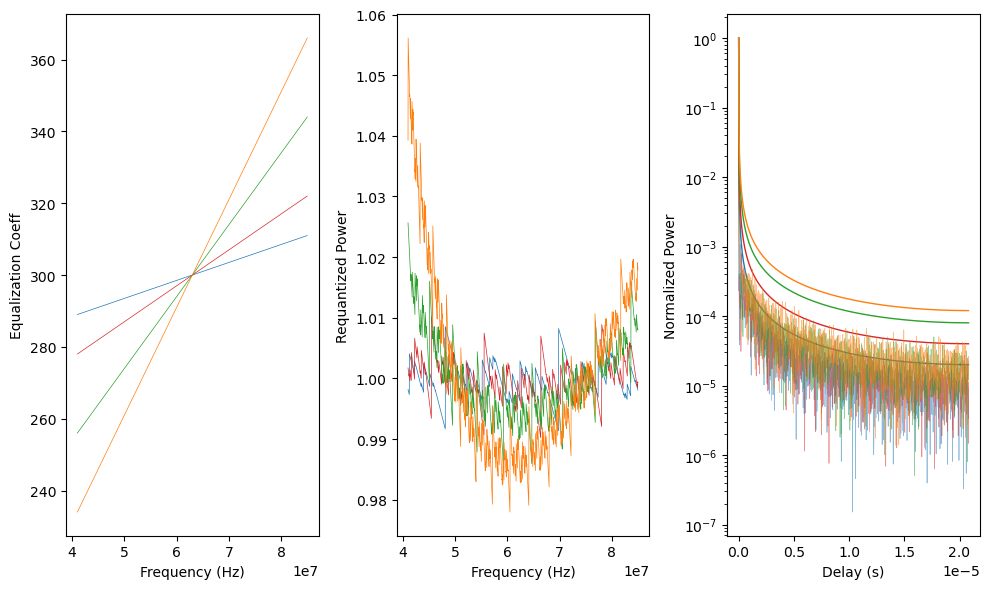

In [ ]:
delays = np.fft.fftfreq(len(frequencies), d=channel_width)
keep_delay_inds = np.where(delays >= 0)[0]
delays = delays[keep_delay_inds]
fig, ax = plt.subplots(ncols=3, figsize=(10, 6))

colors = [
    "tab:blue",
    "tab:red",
    "tab:green",
    "tab:orange",
]
for ind, equalization_coeff_slope in enumerate([0.5e-6, 1e-6, 2e-6, 3e-6]):
    mean_eq_coeff = 300
    equalization_coeffs = (
        equalization_coeff_slope * frequencies
        + mean_eq_coeff
        - equalization_coeff_slope * np.mean(frequencies)
    )
    fft_no_requant = np.fft.fft(input_stddev * equalization_coeffs)[keep_delay_inds]
    fft_no_requant /= np.max(fft_no_requant)

    requantized_vals = requantization_sim(
        initial_quantized_value_options,
        initial_quantized_probabilities,
        equalization_coeffs,
    )
    m, b = np.polyfit(frequencies, requantized_vals, 1)
    requantized_vals_flattened = requantized_vals/(m * frequencies + b)
    requantized_vals_fft = np.fft.fft(requantized_vals_flattened)[keep_delay_inds]
    requantized_vals_fft /= np.max(requantized_vals_fft)

    ax[0].plot(frequencies, equalization_coeffs, "-", linewidth=0.5, color=colors[ind])
    ax[1].plot(
        frequencies, requantized_vals_flattened, "-", linewidth=0.5, color=colors[ind]
    )
    ax[2].plot(delays, np.abs(fft_no_requant), "-", linewidth=1, color=colors[ind])
    ax[2].plot(
        delays,
        np.abs(requantized_vals_fft),
        "-",
        linewidth=0.5,
        color=colors[ind],
        alpha=0.5,
    )

ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Equalization Coeff")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Requantized Power")
ax[2].set_xlabel("Delay (s)")
ax[2].set_ylabel("Normalized Power")
ax[2].set_yscale("log")
plt.tight_layout()
plt.show()